In [1]:
import torch
import warnings
import torchvision
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import vgg19
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Neural_Style(nn.Module):

  def __init__(self):
    super(Neural_Style, self).__init__()
    self.nnet = vgg19(pretrained = True).features.eval().to(device)

  def forward(self,x):
    feature_space = []
    for i,layer in enumerate(self.nnet):
      x = layer(x)
      if i in [4,9,18,27,36]:
        feature_space.append(x)
    return feature_space

In [3]:
original = Image.open('original.jpg')
style = Image.open('style.jpg')

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((400,400)),
    torchvision.transforms.ToTensor()
])

original = transform(original).to(device)
style = transform(style).to(device)

generate = original.clone().requires_grad_(True)
generate = generate.to(device)

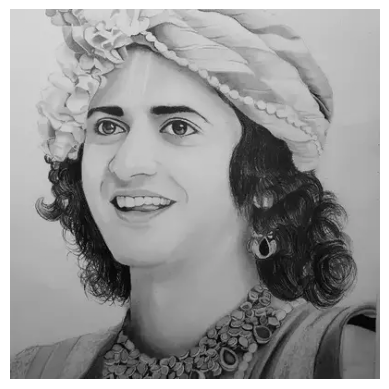

In [4]:
plt.axis('off')
plt.imshow(generate.cpu().permute(1,2,0).detach().numpy())

In [5]:
model = Neural_Style()
epochs = 3000
alpha = 1
beta = 1e4
optimizer = torch.optim.Adam([generate],lr=1e-2)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.2MB/s]


In [6]:
original_features = model(original)
style_features = model(style)
for epoch in range(epochs):
  optimizer.zero_grad()
  generate_features = model(generate)
  content_loss = 0
  style_loss = 0
  for i in range(5):
    content_loss += torch.mean((generate_features[i] - original_features[i])**2)
    style_loss += torch.mean((torch.matmul(generate_features[i].view(generate_features[i].shape[0],-1),
                                           generate_features[i].view(generate_features[i].shape[0],-1).T)
                                          /(generate_features[i].shape[0]*generate_features[i].shape[1])
                        - torch.matmul(style_features[i].view(style_features[i].shape[0],-1),
                                       style_features[i].view(style_features[i].shape[0],-1).T)
                                      /(style_features[i].shape[0]*style_features[i].shape[1]))**2)
  loss = alpha*content_loss + beta*style_loss
  loss.backward(retain_graph=True)
  optimizer.step()
  print("Iteration Number - ",epoch)
  print("Content Loss - ",content_loss)
  print("Style Loss - ", style_loss)
  print("Loss - ",loss)

Streaming output truncated to the last 5000 lines.
Iteration Number -  1750
Content Loss -  tensor(7.8177, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss -  tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
Loss -  tensor(9.9968, device='cuda:0', grad_fn=<AddBackward0>)
Iteration Number -  1751
Content Loss -  tensor(7.8149, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss -  tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
Loss -  tensor(9.9904, device='cuda:0', grad_fn=<AddBackward0>)
Iteration Number -  1752
Content Loss -  tensor(7.8139, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss -  tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
Loss -  tensor(9.9843, device='cuda:0', grad_fn=<AddBackward0>)
Iteration Number -  1753
Content Loss -  tensor(7.8121, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss -  tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
Loss -  tensor(9.9800, device='cuda:0', grad_fn=<AddBackward0>)
Iteration Number -  1754


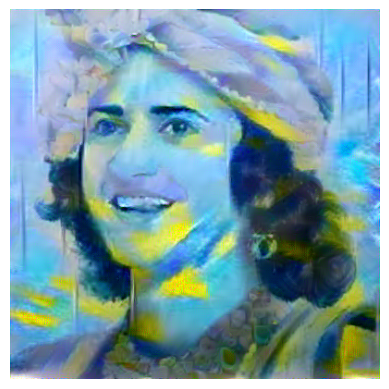

In [7]:
plt.axis('off')
plt.imshow(generate.cpu().permute(1,2,0).detach().numpy())

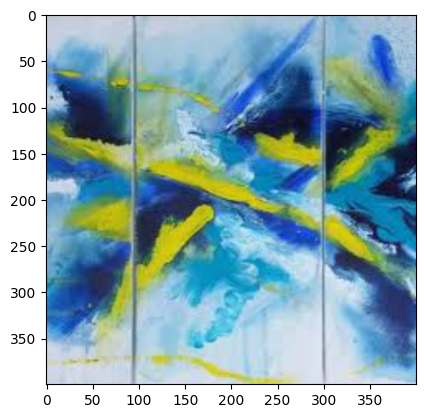

In [8]:
plt.imshow(torchvision.transforms.ToPILImage()(style))